In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
year18 = pd.read_csv("leistung2018.csv")
year19 = pd.read_csv("leistung2019.csv")
year20 = pd.read_csv("leistung2020.csv")
year1820 = pd.concat([year18,year19,year20])
year1820['time'] = year1820['PRODUCT'].str[4:6] + ':00:00'
year1820['date'] = year1820[['DATE_FROM','time']].agg(' '.join, axis=1)
year1820.set_index('date', inplace=True)
year1820.index = pd.to_datetime(year1820.index)
year1820.head()

,DATE_FROM,DATE_TO,TYPE_OF_RESERVES,PRODUCT,TOTAL_MIN_CAPACITY_PRICE_[EUR/MW],TOTAL_AVERAGE_CAPACITY_PRICE_[EUR/MW],TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW],TOTAL_MIN_ENERGY_PRICE_[EUR/MWh],TOTAL_AVERAGE_ENERGY_PRICE_[EUR/MWh],TOTAL_MARGINAL_ENERGY_PRICE_[EUR/MWh],...,GERMANY_IMPORT(-)_EXPORT(+)_[MW],AUSTRIA_MIN_CAPACITY_PRICE_[EUR/MW],AUSTRIA_AVERAGE_CAPACITY_PRICE_[EUR/MW],AUSTRIA_MARGINAL_CAPACITY_PRICE_[EUR/MW],AUSTRIA_MIN_ENERGY_PRICE_[EUR/MWh],AUSTRIA_AVERAGE_ENERGY_PRICE_[EUR/MWh],AUSTRIA_MARGINAL_ENERGY_PRICE_[EUR/MWh],AUSTRIA_IMPORT(-)_EXPORT(+)_[MW],GERMANY_SUM_OF_OFFERED_CAPACITY_[MW],time
date,,,,,,,,,,,,,,,,,,,,,
2018-07-12 00:00:00,7/12/2018,7/12/2018,aFRR,POS_00_04,0.0,47.67,72.82,55.00,95.09,291.9,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00:00
2018-07-12 04:00:00,7/12/2018,7/12/2018,aFRR,POS_04_08,0.0,59.78,100.40,55.00,104.68,348.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04:00:00
2018-07-12 08:00:00,7/12/2018,7/12/2018,aFRR,POS_08_12,0.0,63.96,97.42,58.15,88.81,333.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,08:00:00
2018-07-12 12:00:00,7/12/2018,7/12/2018,aFRR,POS_12_16,0.0,59.82,100.80,58.80,93.62,348.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12:00:00
2018-07-12 16:00:00,7/12/2018,7/12/2018,aFRR,POS_16_20,0.0,62.96,102.08,58.80,89.52,400.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16:00:00


# Outlier and average marginal price of the positive Regelleistungsmarkt

In [4]:
year1820_pos = year1820[year1820['PRODUCT'].str[0:3]=='POS']
year1820_pos_xy = year1820_pos[['TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW]']]
year1820_pos_avg = year1820_pos[['TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW]', 'TOTAL_AVERAGE_CAPACITY_PRICE_[EUR/MW]']]

In [5]:
outlier = year1820_pos_xy[year1820_pos_xy['TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW]'] > 400]
outlier

,TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW]
date,
2018-08-06 12:00:00,950.57
2018-08-06 16:00:00,1139.57
2018-08-06 20:00:00,1117.53
2018-08-07 12:00:00,500.00
2018-08-07 16:00:00,587.77
2018-08-07 20:00:00,569.23
2019-05-16 12:00:00,99900.00
2019-07-01 00:00:00,979.70
2019-07-01 04:00:00,978.89


<AxesSubplot:xlabel='date'>

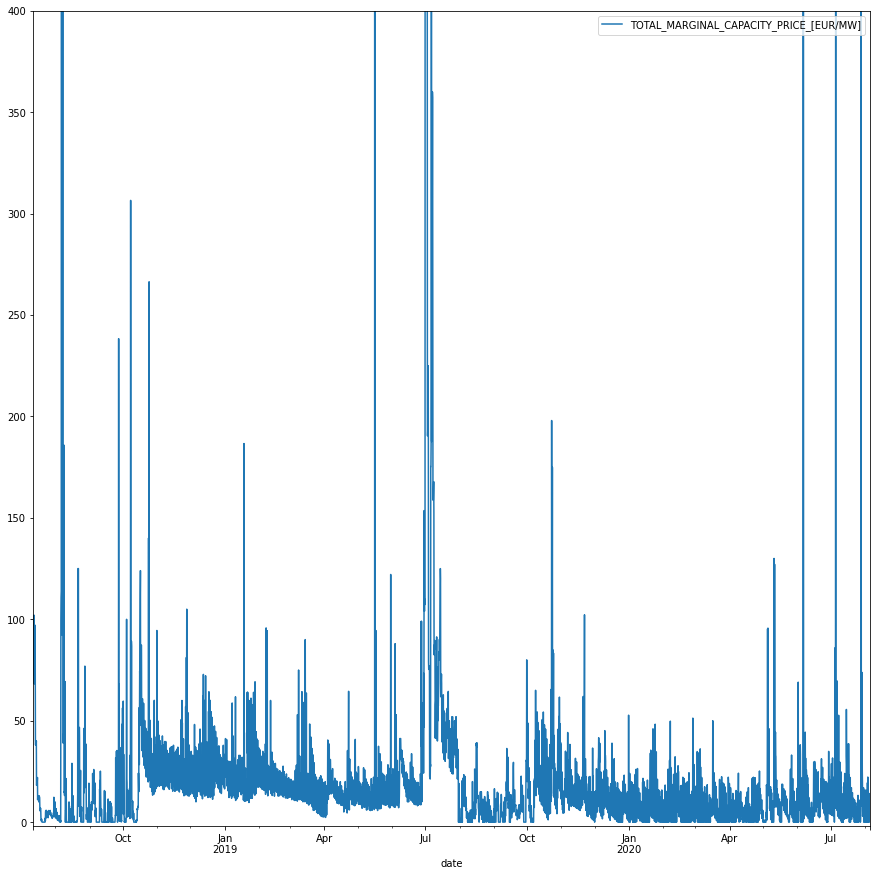

In [6]:
year1820_pos_xy.plot(figsize=(15,15), ylim=(-2,400))
# year1820_pos_xy.plot(figsize=(15,15))

<AxesSubplot:xlabel='date'>

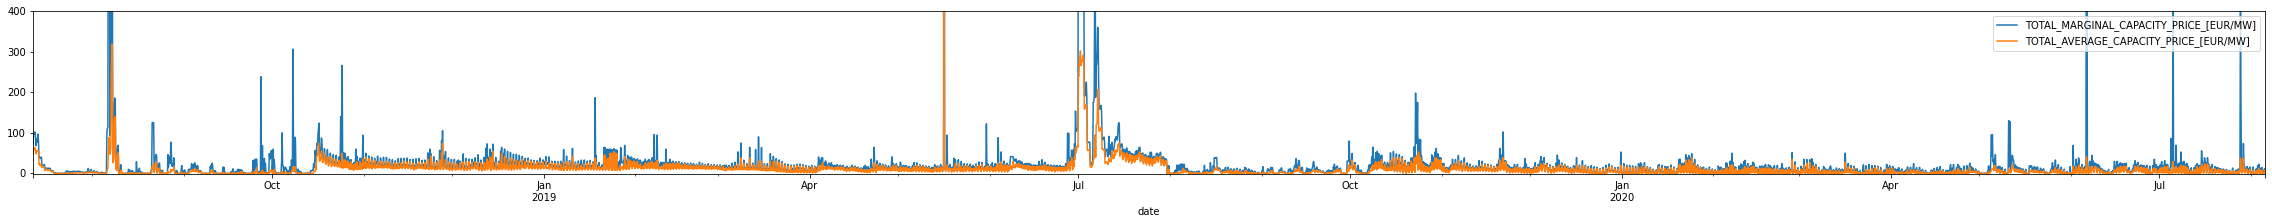

In [7]:
year1820_pos_avg.plot(figsize=(40,3), ylim=(-2,400))

<AxesSubplot:xlabel='date,date'>

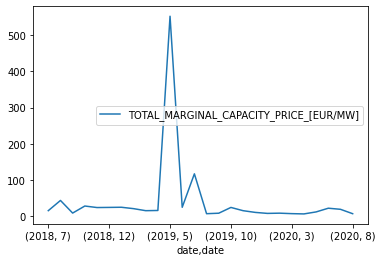

In [8]:
seasonal = year1820_pos_xy.groupby(by=[year1820_pos_xy.index.year, year1820_pos_xy.index.month]).mean()
seasonal.plot()

In [10]:
year1820_pos_avg['diff'] = year1820_pos_avg['TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW]'] - year1820_pos_avg['TOTAL_AVERAGE_CAPACITY_PRICE_[EUR/MW]']
year1820_pos_avg.head()

<ipython-input-10-01ca6c82f248>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year1820_pos_avg['diff'] = year1820_pos_avg['TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW]'] - year1820_pos_avg['TOTAL_AVERAGE_CAPACITY_PRICE_[EUR/MW]']


,TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW],TOTAL_AVERAGE_CAPACITY_PRICE_[EUR/MW],diff
date,,,
2018-07-12 00:00:00,72.82,47.67,25.15
2018-07-12 04:00:00,100.40,59.78,40.62
2018-07-12 08:00:00,97.42,63.96,33.46
2018-07-12 12:00:00,100.80,59.82,40.98
2018-07-12 16:00:00,102.08,62.96,39.12


TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW]    40.978947
TOTAL_AVERAGE_CAPACITY_PRICE_[EUR/MW]     10.966669
diff                                      30.012278
dtype: float64
3.7366812682985024


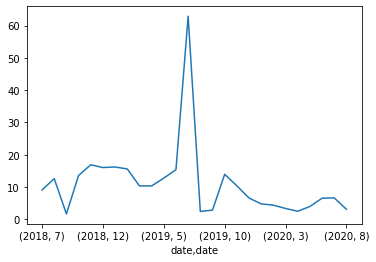

In [11]:
seasonal_avg = year1820_pos_avg.groupby(by=[year1820_pos_avg.index.year, year1820_pos_avg.index.month]).mean()
seasonal_avg['TOTAL_AVERAGE_CAPACITY_PRICE_[EUR/MW]'].plot()
print(seasonal_avg.mean())
print(seasonal_avg.mean()['TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW]']/seasonal_avg.mean()['TOTAL_AVERAGE_CAPACITY_PRICE_[EUR/MW]'])

average and std of the difference of positive price 31.676444003527333 1476.5650139966208
average and std of the difference of positive price excluding outliers 7.040237197960542 14.370863517423286
average and std of the difference of positive price with maximal difference 250 7.202905225863596 15.120932719532346
PLOT: difference histogram


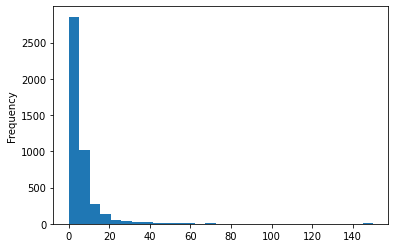

<AxesSubplot:ylabel='Frequency'>

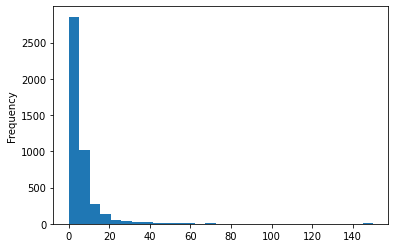

In [16]:
diff = year1820_pos_avg['diff']
print('average and std of the difference of positive price', diff.mean(), diff.std())
diff_wo_outlier = year1820_pos_avg[year1820_pos_avg['TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW]'] < 400]['diff']
print('average and std of the difference of positive price excluding outliers', diff_wo_outlier.mean(), diff_wo_outlier.std())
diff = diff[diff < 250]
print('average and std of the difference of positive price with maximal difference 250', diff.mean(), diff.std())
print('PLOT: difference histogram')
diff.plot(kind='hist', bins=np.linspace(0,150,30))
plt.show()
diff_wo_outlier.plot(kind='hist', bins=np.linspace(0,150,30))

0.45146127377498807 0.2456996229061388
PLOT: difference histogram in percentage


<AxesSubplot:ylabel='Frequency'>

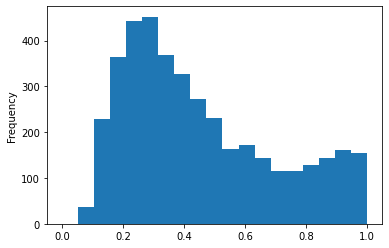

In [17]:
diff_percent = year1820_pos_avg['diff']/year1820_pos_avg['TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW]']
print(diff_percent.mean(), diff_percent.std())
print('PLOT: difference histogram in percentage')
diff_percent.plot(kind='hist', bins=np.linspace(0,1,20))

In [36]:
print('promised average surplus pro MW:', (year1820_pos_avg['TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW]'] * diff_percent.std()).mean())

promised average surplus pro MW: 10.556982583333335


In [39]:
wo_outlier =  year1820_pos_avg[year1820_pos_avg['TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW]'] <400]
print('promised moderate average surplus pro MW:', (wo_outlier['TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW]'] * diff_percent.std()).mean())

promised moderate average surplus pro MW: 4.235583173680585


In [21]:
year1820_pos_avg.head()

,TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW],TOTAL_AVERAGE_CAPACITY_PRICE_[EUR/MW],diff
date,,,
2018-07-12 00:00:00,72.82,47.67,25.15
2018-07-12 04:00:00,100.40,59.78,40.62
2018-07-12 08:00:00,97.42,63.96,33.46
2018-07-12 12:00:00,100.80,59.82,40.98
2018-07-12 16:00:00,102.08,62.96,39.12


PLOT: difference histogram excluding 0 Leistungspreis
2.919441441362838 9.48640241231346


<AxesSubplot:ylabel='Frequency'>

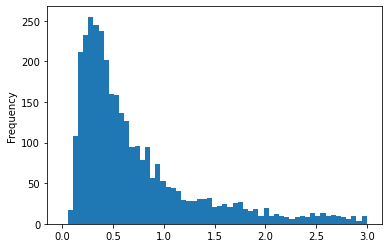

In [23]:
filter_diff = year1820_pos_avg[year1820_pos_avg['TOTAL_AVERAGE_CAPACITY_PRICE_[EUR/MW]']!=0]
diff_avg_percent = filter_diff['diff']/filter_diff['TOTAL_AVERAGE_CAPACITY_PRICE_[EUR/MW]']
print('PLOT: difference histogram excluding 0 Leistungspreis')
print(diff_avg_percent.mean(), diff_avg_percent.std())
diff_avg_percent.plot(kind='hist', bins=np.linspace(0,3,60))

## The same analysis for the negative market

In [24]:
year1820_neg = year1820[year1820['PRODUCT'].str[0:3]=='NEG']
year1820_neg_xy = year1820_neg[['TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW]']]
year1820_neg_avg = year1820_neg[['TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW]', 'TOTAL_AVERAGE_CAPACITY_PRICE_[EUR/MW]']]

In [27]:
outlier = year1820_neg_xy[year1820_neg_xy['TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW]'] > 400]
outlier

,TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW]
date,
2019-06-30 16:00:00,500.0
2020-07-28 16:00:00,969.0


<AxesSubplot:xlabel='date'>

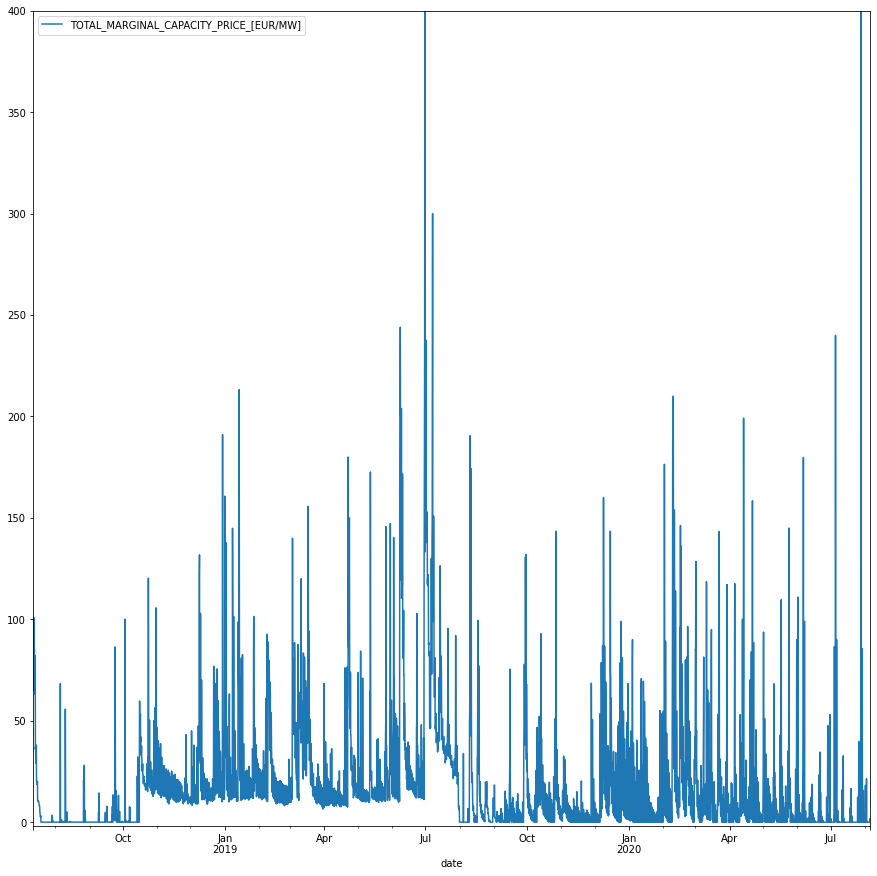

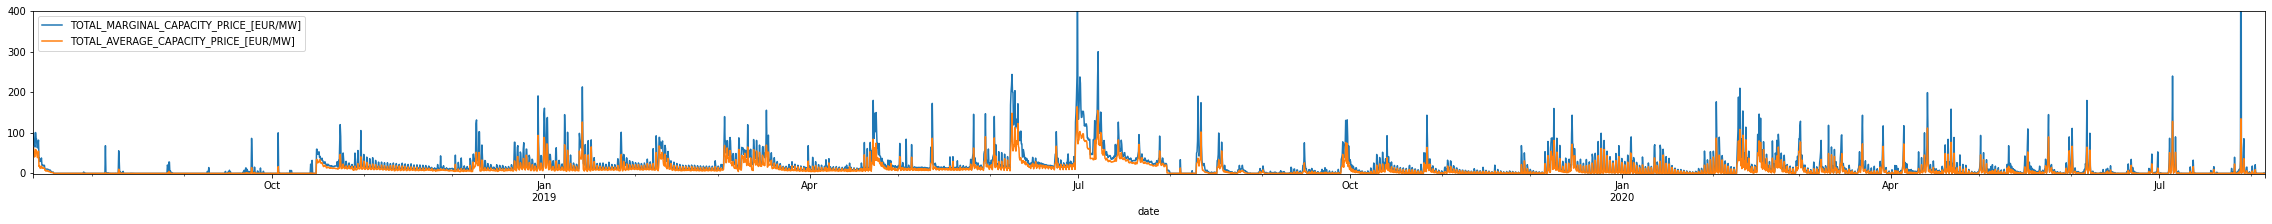

In [30]:
year1820_neg_xy.plot(figsize=(15,15), ylim=(-2,400))
year1820_neg_avg.plot(figsize=(40,3), ylim=(-2,400))

<AxesSubplot:xlabel='date,date'>

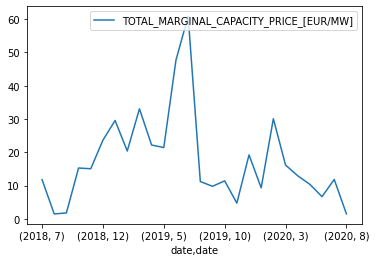

In [31]:
seasonal_neg = year1820_neg_xy.groupby(by=[year1820_pos_xy.index.year, year1820_pos_xy.index.month]).mean()
seasonal_neg.plot()

In [32]:
year1820_neg_avg['diff'] = year1820_neg_avg['TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW]'] - year1820_neg_avg['TOTAL_AVERAGE_CAPACITY_PRICE_[EUR/MW]']
year1820_neg_avg.head()

<ipython-input-32-f787f1b79b85>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year1820_neg_avg['diff'] = year1820_neg_avg['TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW]'] - year1820_neg_avg['TOTAL_AVERAGE_CAPACITY_PRICE_[EUR/MW]']


,TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW],TOTAL_AVERAGE_CAPACITY_PRICE_[EUR/MW],diff
date,,,
2018-07-12 00:00:00,99.88,63.93,35.95
2018-07-12 04:00:00,99.88,63.20,36.68
2018-07-12 08:00:00,69.36,47.31,22.05
2018-07-12 12:00:00,67.64,40.52,27.12
2018-07-12 16:00:00,64.98,42.20,22.78


average and std of the difference of negative price 7.9182826278659615 19.213195736021277
average and std of the difference of negative price excluding outliers 7.662955447728274 13.941423088779304
average and std of the difference of negative price with maximal difference 250 7.662955447728274 13.941423088779304
PLOT: difference histogram


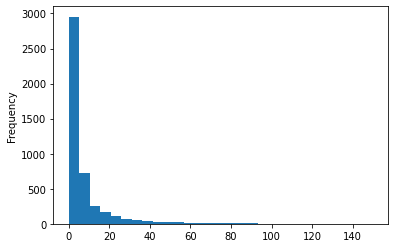

<AxesSubplot:ylabel='Frequency'>

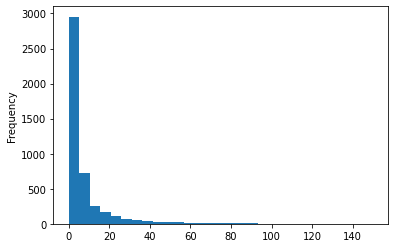

In [33]:
diff_neg = year1820_neg_avg['diff']
print('average and std of the difference of negative price', diff_neg.mean(), diff_neg.std())
diff_wo_outlier_neg = year1820_neg_avg[year1820_neg_avg['TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW]'] < 400]['diff']
print('average and std of the difference of negative price excluding outliers', diff_wo_outlier_neg.mean(), diff_wo_outlier_neg.std())
diff_neg = diff_neg[diff_neg < 250]
print('average and std of the difference of negative price with maximal difference 250', diff_neg.mean(), diff_neg.std())
print('PLOT: difference histogram')
diff_neg.plot(kind='hist', bins=np.linspace(0,150,30))
plt.show()
diff_wo_outlier_neg.plot(kind='hist', bins=np.linspace(0,150,30))

0.47225222554016233 0.2189108071552298
PLOT: difference histogram in percentage


<AxesSubplot:ylabel='Frequency'>

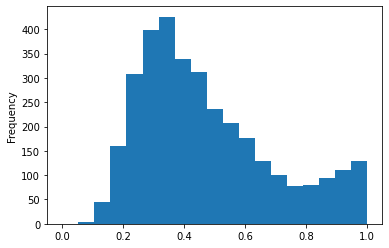

In [35]:
diff_percent_neg = year1820_neg_avg['diff']/year1820_neg_avg['TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW]']
print(diff_percent_neg.mean(), diff_percent_neg.std())
print('PLOT: difference histogram in percentage')
diff_percent_neg.plot(kind='hist', bins=np.linspace(0,1,20))

In [38]:
print('promised average surplus pro MW:', (year1820_neg_avg['TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW]'] * diff_percent_neg.std()).mean())
wo_outlier_neg =  year1820_neg_avg[year1820_neg_avg['TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW]'] <400]
print('promised moderate average surplus pro MW:', (wo_outlier_neg['TOTAL_MARGINAL_CAPACITY_PRICE_[EUR/MW]'] * diff_percent_neg.std()).mean())

promised average surplus pro MW: 4.00548478096045
promised moderate average surplus pro MW: 3.936325317760381
